Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Written /content/drive/MyDrive/adhd-accel-avg/bridge1.csv
Written /content/drive/MyDrive/adhd-accel-avg/bridge2.csv
Written /content/drive/MyDrive/adhd-accel-avg/bridge3.csv
Written /content/drive/MyDrive/adhd-accel-avg/bridge4.csv
Written /content/drive/MyDrive/adhd-accel-avg/bridge5.csv
Written /content/drive/MyDrive/adhd-vel-avg/bridge1.csv
Written /content/drive/MyDrive/adhd-vel-avg/bridge2.csv
Written /content/drive/MyDrive/adhd-vel-avg/bridge3.csv
Written /content/drive/MyDrive/adhd-vel-avg/bridge4.csv
Written /content/drive/MyDrive/adhd-vel-avg/bridge5.csv
Written /content/drive/MyDrive/no-adhd-accel-avg/bridge1.csv
Written /content/drive/MyDrive/no-adhd-accel-avg/bridge2.csv
Written /content/drive/MyDrive/no-adhd-accel-avg/bridge3.csv
Written /content/drive/MyDrive/no-adhd-accel-avg/bridge4.csv
Written /content/drive/MyDrive/no-adhd-accel-avg/bridge5.

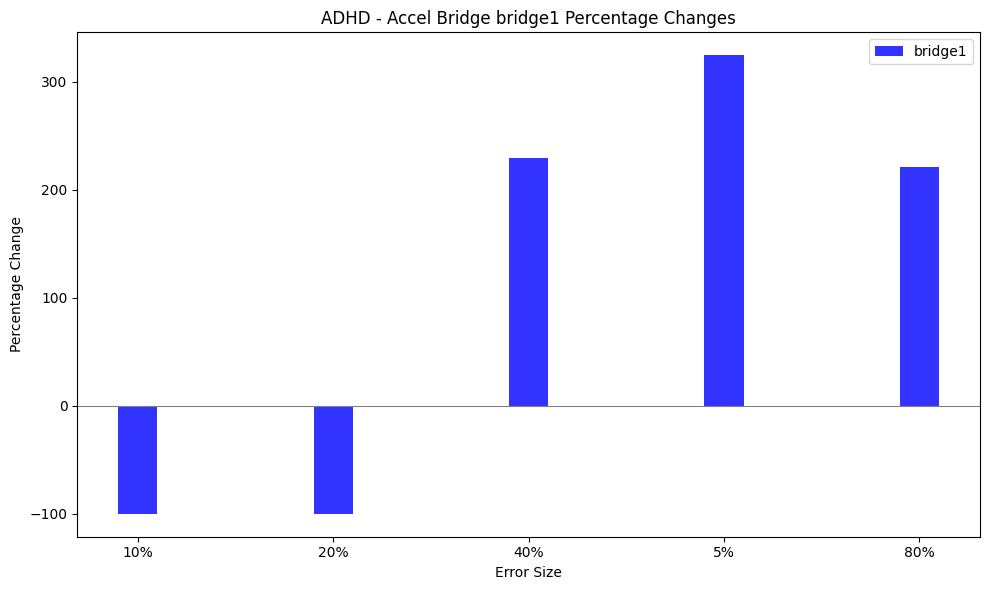

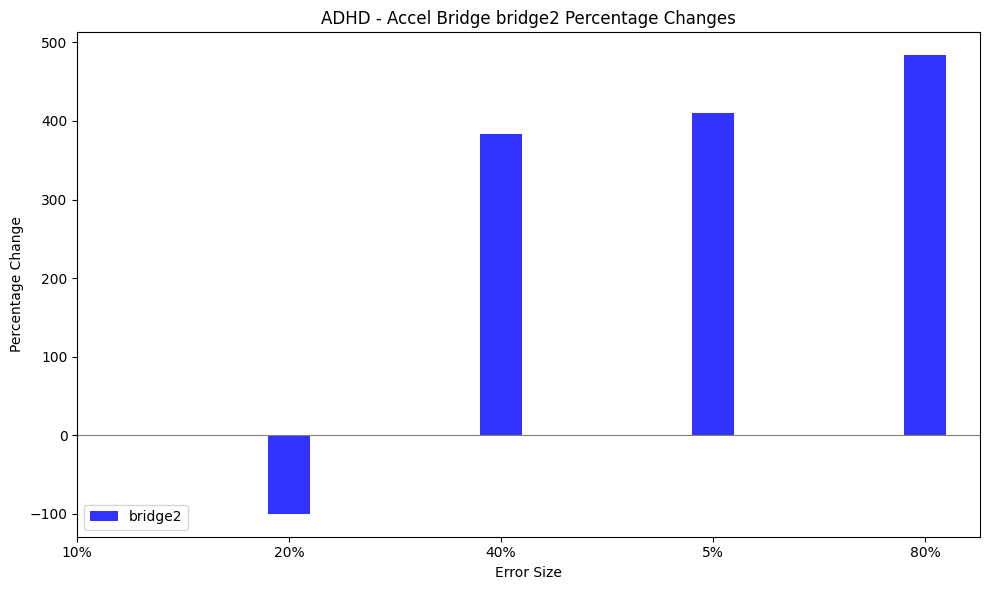

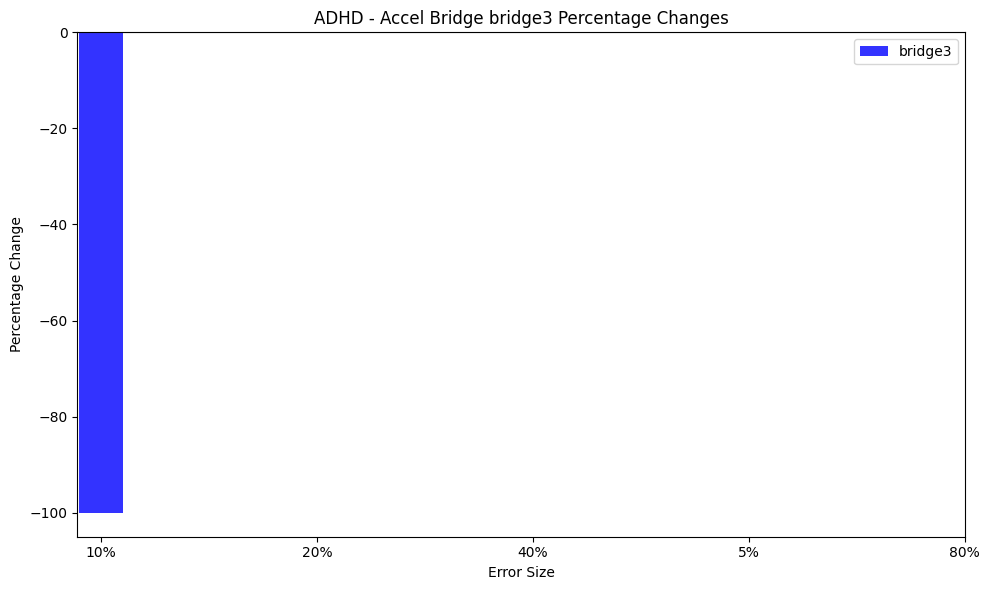

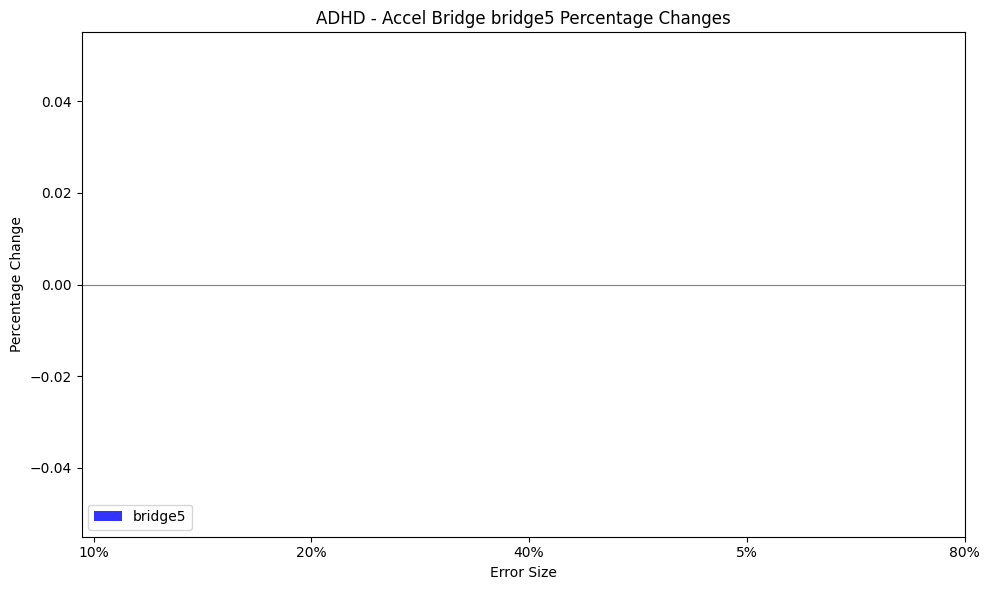

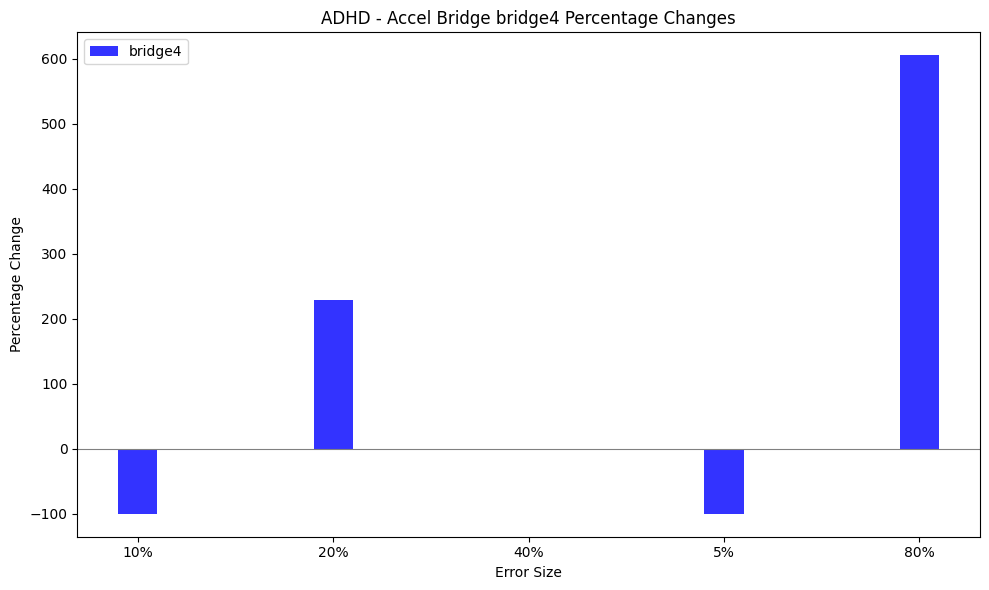

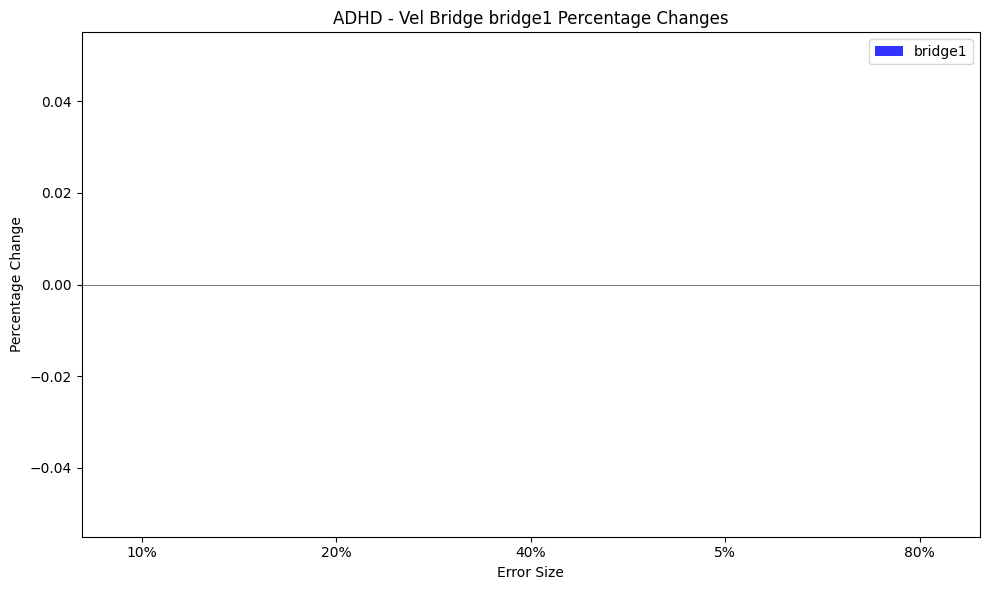

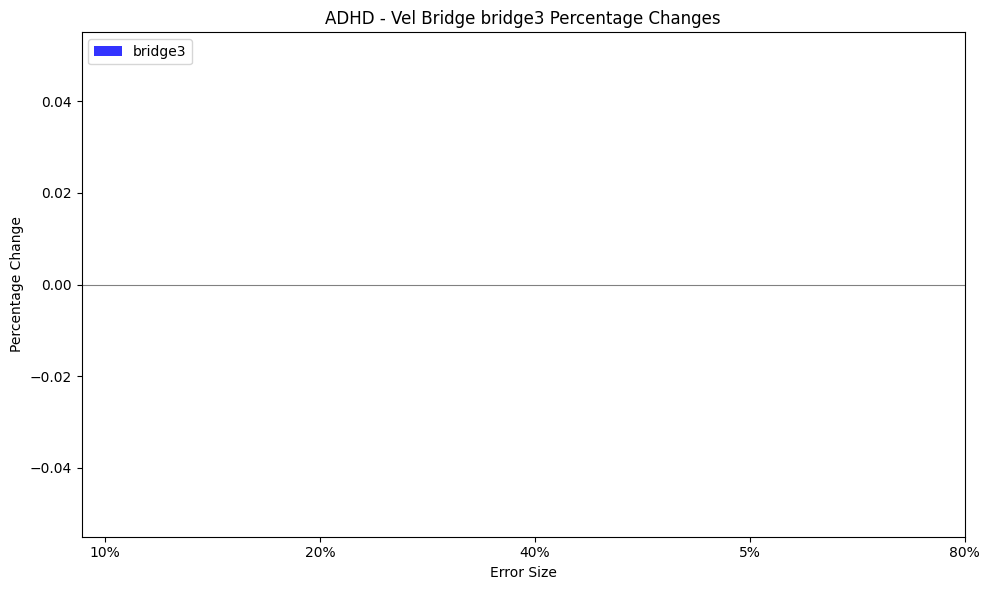

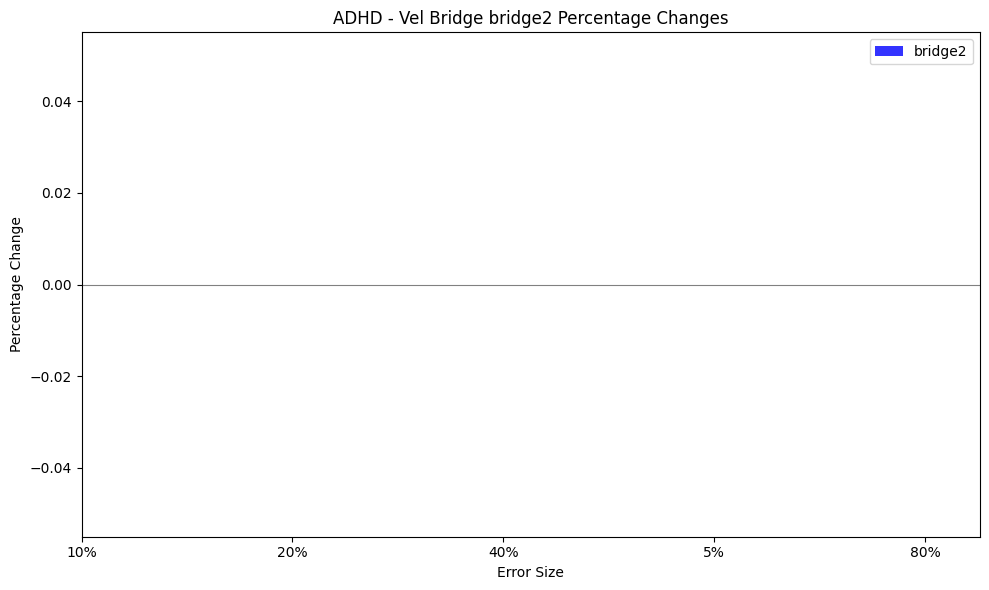

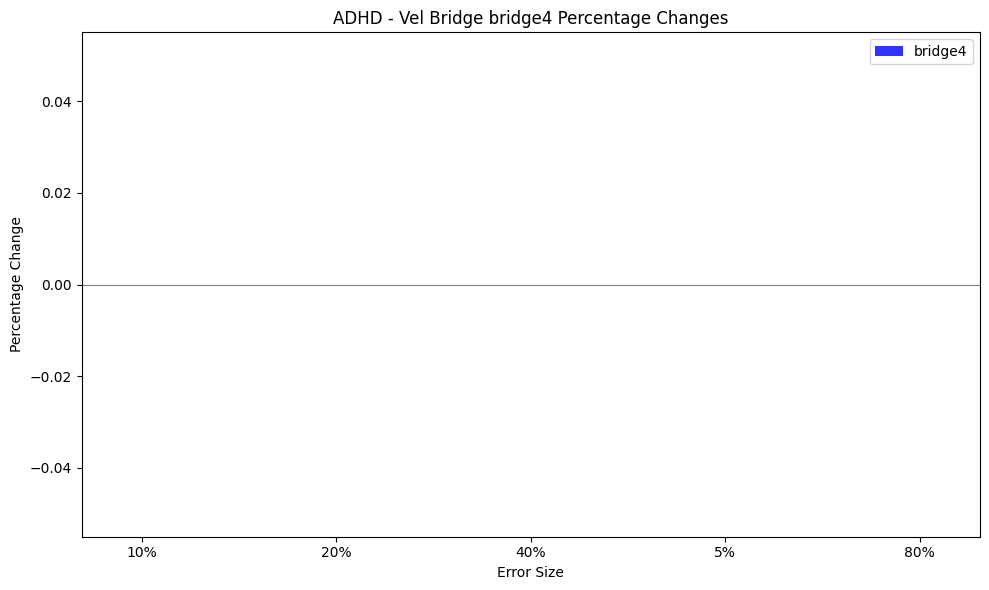

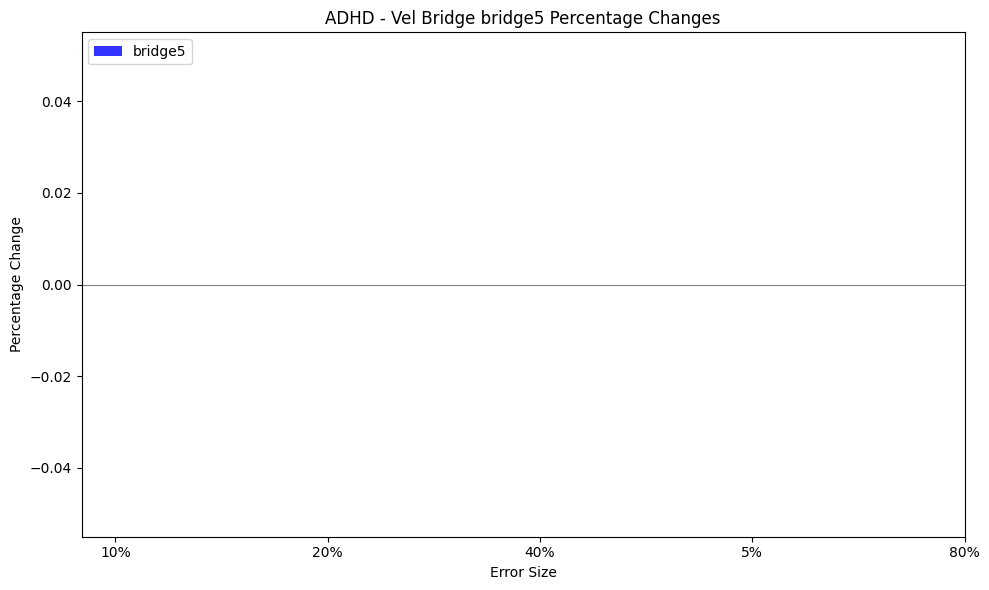

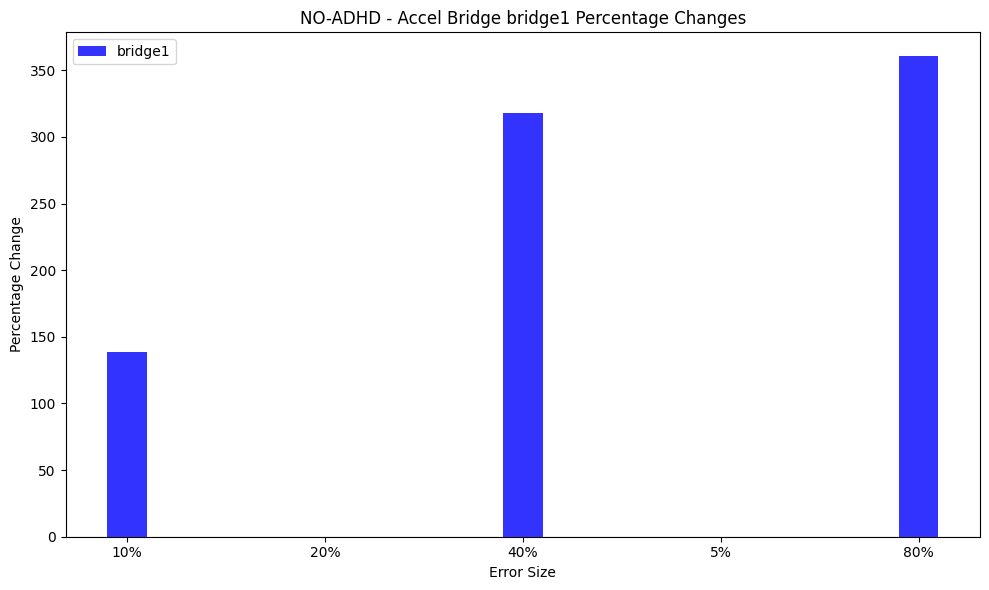

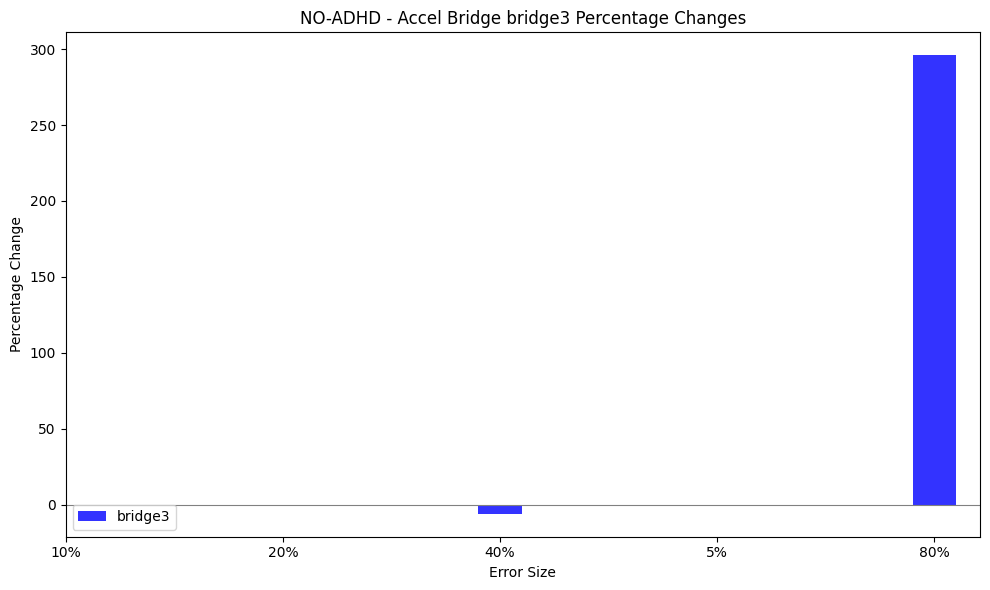

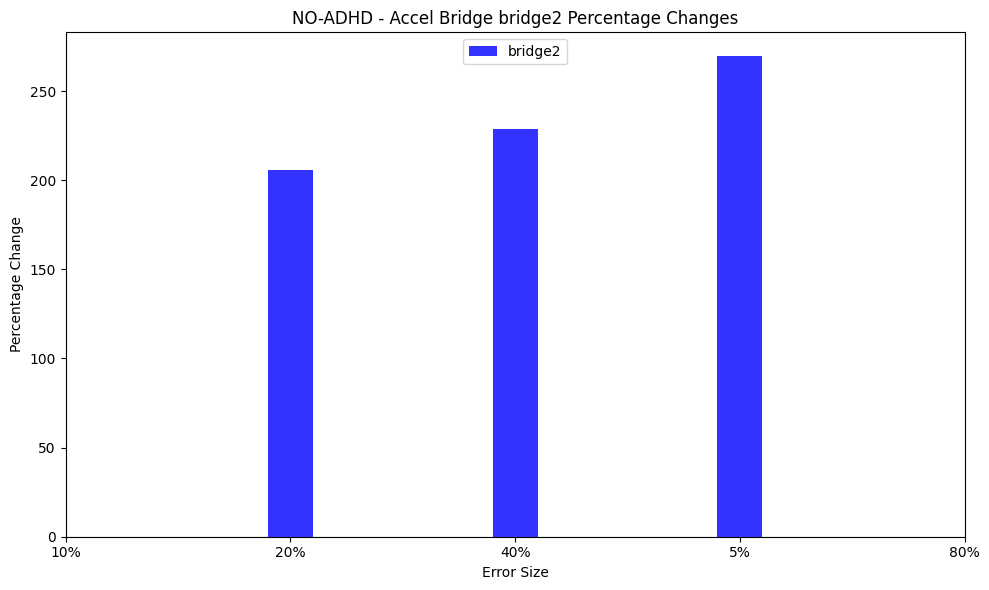

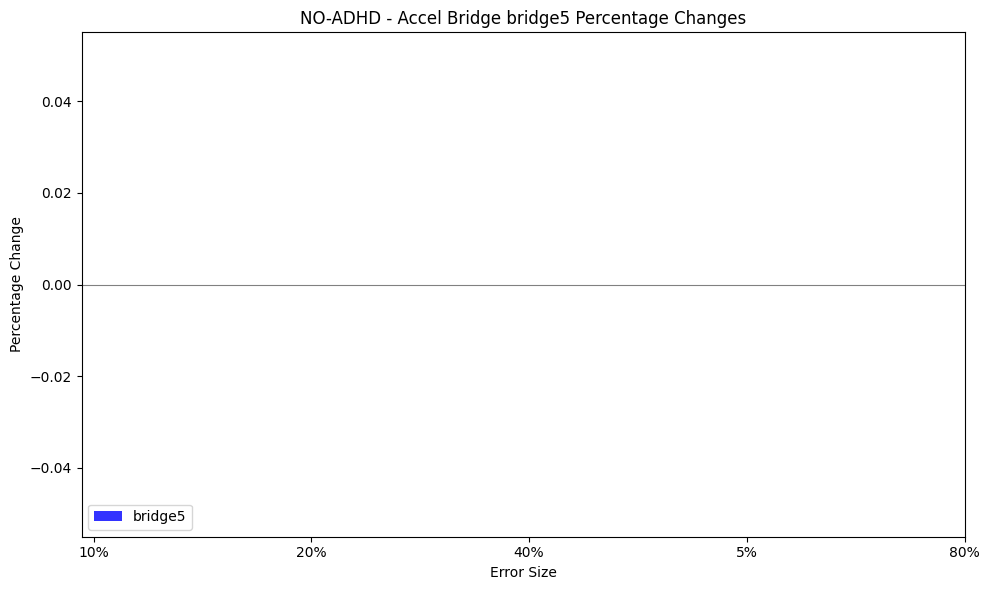

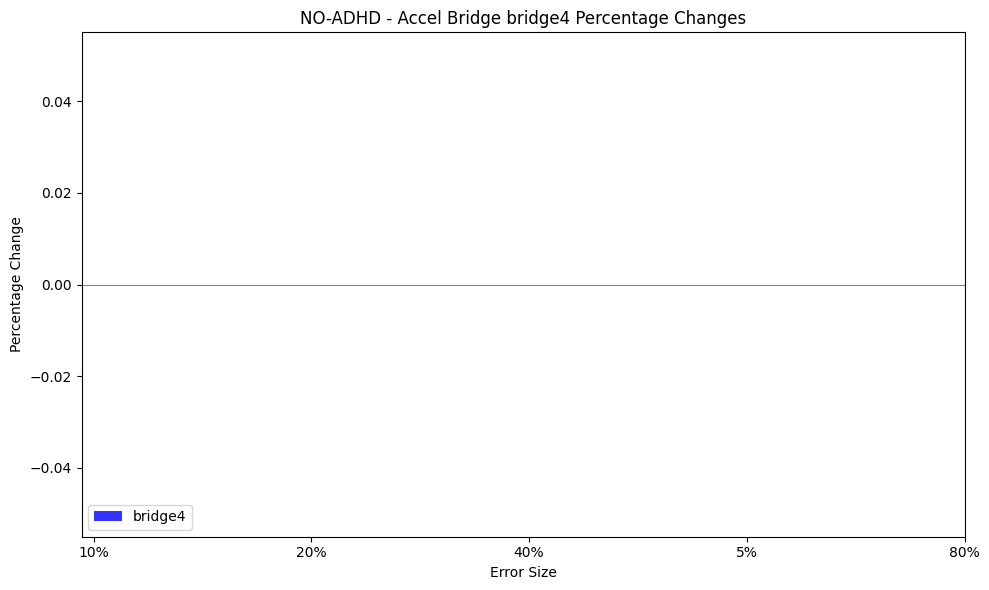

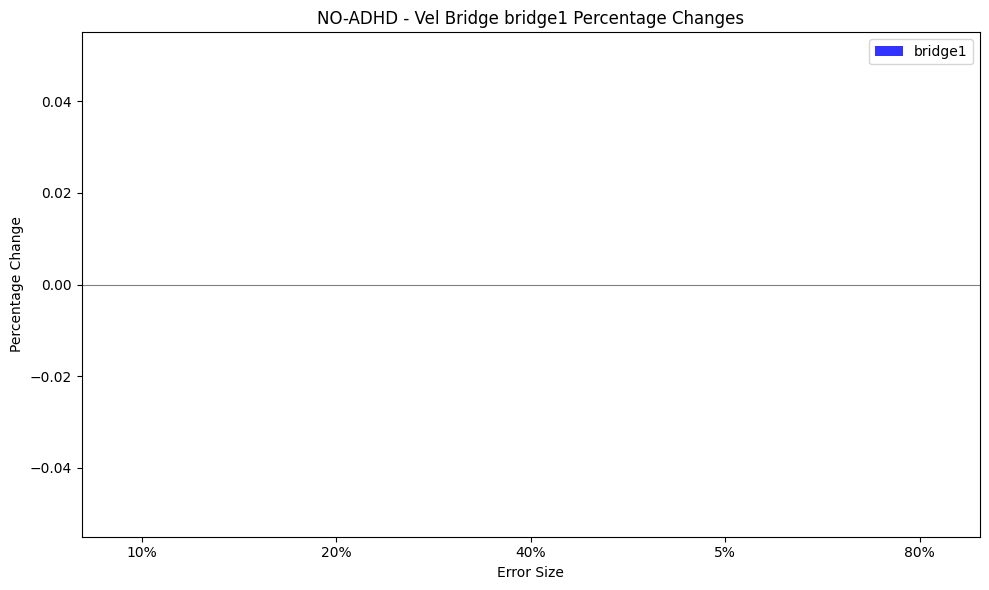

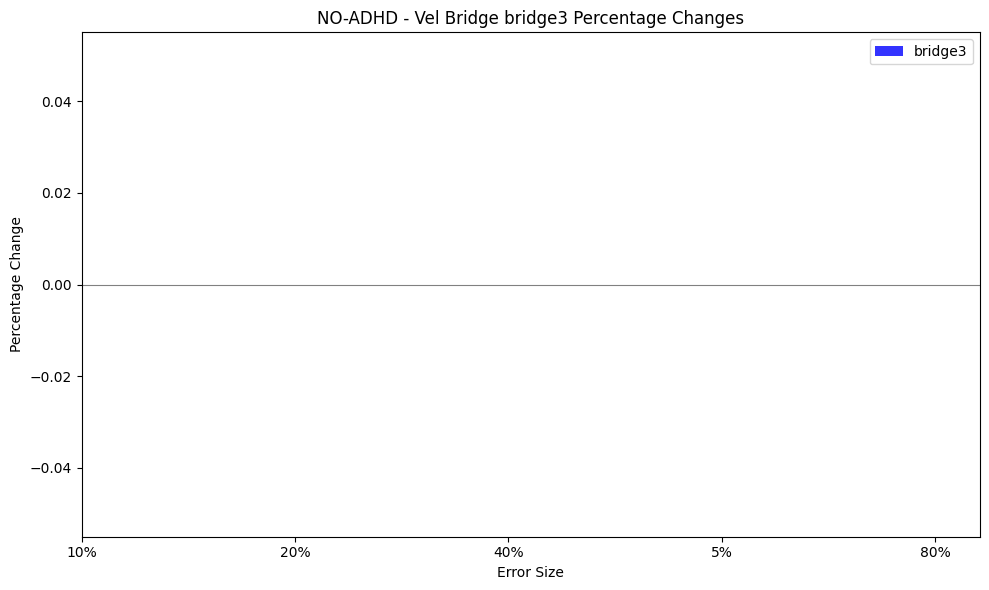

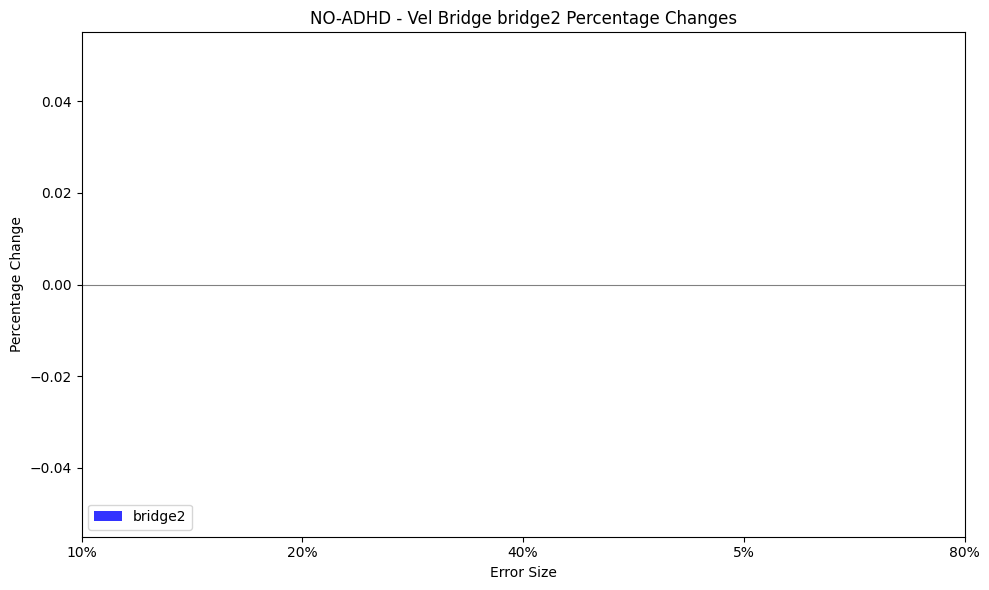

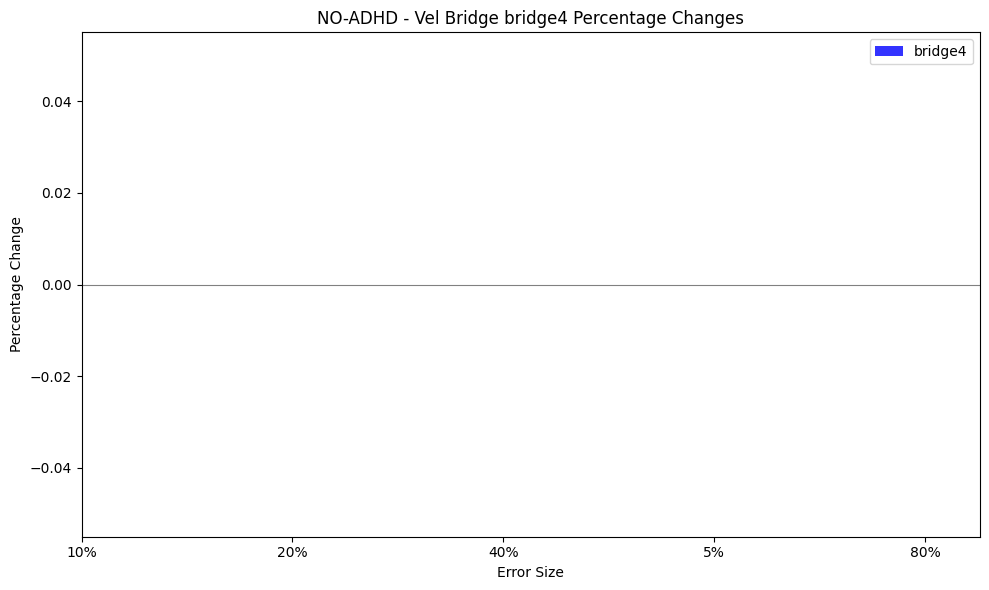

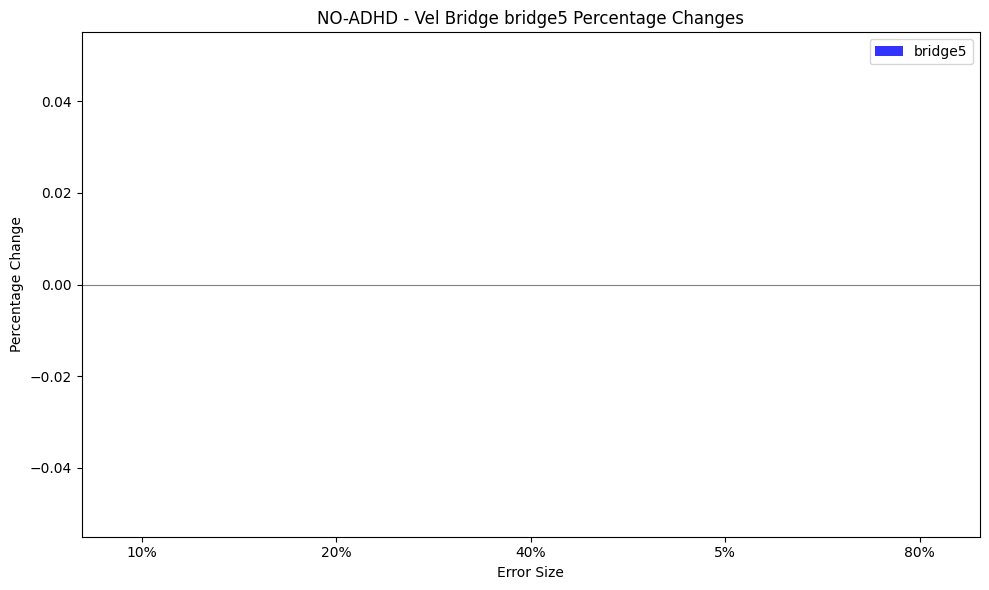

In [ ]:
import numpy as np
import pandas as pd
import zipfile
import os
from io import BytesIO
import matplotlib.pyplot as plt
from google.colab import drive

drive.mount('/content/drive')

adhd_map_accel = {'1':{'0%':[], '5%':[], '10%':[], '20%':[], '40%':[], '80%':[]},
            '2':{'0%':[], '5%':[], '10%':[], '20%':[], '40%':[], '80%':[]},
            '3':{'0%':[], '5%':[], '10%':[], '20%':[], '40%':[], '80%':[]},
            '4':{'0%':[], '5%':[], '10%':[], '20%':[], '40%':[], '80%':[]},
            '5':{'0%':[], '5%':[], '10%':[], '20%':[], '40%':[], '80%':[]}}
adhd_map_vel = {'1':{'0%':[], '5%':[], '10%':[], '20%':[], '40%':[], '80%':[]},
            '2':{'0%':[], '5%':[], '10%':[], '20%':[], '40%':[], '80%':[]},
            '3':{'0%':[], '5%':[], '10%':[], '20%':[], '40%':[], '80%':[]},
            '4':{'0%':[], '5%':[], '10%':[], '20%':[], '40%':[], '80%':[]},
            '5':{'0%':[], '5%':[], '10%':[], '20%':[], '40%':[], '80%':[]}}
no_adhd_map_accel = {'1':{'0%':[], '5%':[], '10%':[], '20%':[], '40%':[], '80%':[]},
            '2':{'0%':[], '5%':[], '10%':[], '20%':[], '40%':[], '80%':[]},
            '3':{'0%':[], '5%':[], '10%':[], '20%':[], '40%':[], '80%':[]},
            '4':{'0%':[], '5%':[], '10%':[], '20%':[], '40%':[], '80%':[]},
            '5':{'0%':[], '5%':[], '10%':[], '20%':[], '40%':[], '80%':[]}}
no_adhd_map_vel = {'1':{'0%':[], '5%':[], '10%':[], '20%':[], '40%':[], '80%':[]},
            '2':{'0%':[], '5%':[], '10%':[], '20%':[], '40%':[], '80%':[]},
            '3':{'0%':[], '5%':[], '10%':[], '20%':[], '40%':[], '80%':[]},
            '4':{'0%':[], '5%':[], '10%':[], '20%':[], '40%':[], '80%':[]},
            '5':{'0%':[], '5%':[], '10%':[], '20%':[], '40%':[], '80%':[]}}

def load_and_process_data_final(zip_path):
    with zipfile.ZipFile(zip_path, 'r') as z:
        data_logs = {}
        error_sizes = {}
        categories = {'ADHD': {}, 'NO_ADHD': {}}

        # Extract and categorize DataLog and ErrorSizes files
        for file_name in z.namelist():
            if file_name.endswith('.csv'):
                participant_id = file_name.split('/')[1]
                file_type = 'DataLog' if 'DataLog' in file_name else 'ErrorSizes'
                map_id = file_name.split('_')[-1]
                category = 'ADHD' if 'NO_ADHD' not in participant_id else 'NO_ADHD'

                with z.open(file_name) as file:
                    df = pd.read_csv(file)

                if file_type == 'DataLog':
                    if participant_id not in data_logs:
                        data_logs[participant_id] = {}
                    data_logs[participant_id][map_id] = df
                else:
                    if participant_id not in error_sizes:
                        error_sizes[participant_id] = {}
                    error_sizes[participant_id][map_id] = df

        for participant_id, maps in data_logs.items():
            category = 'ADHD' if 'NO_ADHD' not in participant_id else 'NO_ADHD'
            if participant_id not in categories[category]:
                categories[category][participant_id] = {}
            for map_id, data_log in maps.items():
                errors_sizes = error_sizes[participant_id][map_id]
                results = analyze_map_data(data_log, errors_sizes, category)
                categories[category][participant_id][map_id] = results

        return categories

def analyze_map_data(data_log, errors_sizes, category):
    err_index = str(errors_sizes['Err_Bridge'][0])  # Convert to string
    err_size = errors_sizes['Err_Size'][0]

    if err_size not in ['0%', '5%', '10%', '20%', '40%', '80%']:
        print(f"Error size {err_size} not expected!")
        return None  # Handle the unexpected size appropriately

    # Assuming 5 bridges, explicitly define bridge_data without a for loop
    bridge_data = {
        '1': {'Accel': [], 'Vel': []},
        '2': {'Accel': [], 'Vel': []},
        '3': {'Accel': [], 'Vel': []},
        '4': {'Accel': [], 'Vel': []},
        '5': {'Accel': [], 'Vel': []}
    }

    index_count = 0

    for i in range(len(data_log['After_Err'])):
        if data_log['After_Err'][i] == False and i+1 < len(data_log['After_Err']) and data_log['After_Err'][i+1] == True:
            index_count += 1  # Increment to next bridge index
        if data_log['After_Err'][i] == True:
            bridge_data[str(index_count)]['Accel'].append(data_log['Accel_Magnitude'][i])
            bridge_data[str(index_count)]['Vel'].append(data_log['Vel_Magnitutde'][i])

    target_map_accel = adhd_map_accel if category == 'ADHD' else no_adhd_map_accel
    target_map_vel = adhd_map_vel if category == 'ADHD' else no_adhd_map_vel

    # Calculate means and update maps for all bridges
    for bridge in bridge_data:
        avg_acceleration = calc_mean(bridge_data[bridge]['Accel']) if bridge_data[bridge]['Accel'] else 0
        avg_velocity = calc_mean(bridge_data[bridge]['Vel']) if bridge_data[bridge]['Vel'] else 0

        if bridge == err_index:
            target_map_accel[bridge][err_size].append(avg_acceleration)
            target_map_vel[bridge][err_size].append(avg_velocity)
        else:
            target_map_accel[bridge]['0%'].append(avg_acceleration)
            target_map_vel[bridge]['0%'].append(avg_velocity)

    return {'average_speed': avg_velocity, 'average_acceleration': avg_acceleration}

def write_maps_to_csv(main_map, folder_name):
    # Create directory for the results
    base_path = '/content/drive/MyDrive/'  # Base path for Google Drive
    folder_path = os.path.join(base_path, folder_name)
    if not os.path.exists(folder_path):
        os.makedirs(folder_path)

    for key, sub_map in main_map.items():
        data = {err_size: calc_mean(values) if values else None for err_size, values in sub_map.items()}
        df = pd.DataFrame([data])
        file_path = os.path.join(folder_path, f'bridge{key}.csv')
        df.to_csv(file_path, index=False)
        print(f'Written {file_path}')

def calc_mean(array):
    if len(array) > 0:
        return sum(array) / len(array)
    else:
        return None

def calculate_changes_for_each_bridge(base_folder_path):
    # List all subfolders in the base folder, each one represents a different group and metric
    subfolders = [f.path for f in os.scandir(base_folder_path) if f.is_dir()]

    for folder in subfolders:
        # Parsing group and metric from folder name
        if 'avg' in folder:
         group, metric = folder.split('/')[-1].split('-')[:2]
        else:
         continue
        print(f"Processing {group} data for {metric}...")
        files = os.listdir(folder)

        # Read and calculate changes for each bridge file
        for file in files:
            bridge_id = file.replace('.csv', '')  # Extracting bridge identifier from file name
            df = pd.read_csv(os.path.join(folder, file))

            # Assuming '0%' column is the baseline; calculate changes for each error size
            if '0%' in df.columns:
                print(df['0%'][0])
                baseline_value = df['0%'][0]
            else:
                print(f"No baseline '0%' found in {file}. Skipping...")
                continue

            changes = {}
            for error_size in df.columns:
                if error_size == '0%':
                    continue  # Skip baseline column

                current_value = df[error_size][0]
                percentage_change = calculate_percentage_change(current_value, baseline_value)
                changes[error_size] = percentage_change

            # Save the changes to a new CSV within the same folder
            changes_df = pd.DataFrame([changes])
            output_file_path = os.path.join(folder, f'{bridge_id}_changes.csv')
            changes_df.to_csv(output_file_path, index=False)
            print(f"Written percentage changes to {output_file_path}")

def calculate_percentage_change(current_value, baseline_value):
    if baseline_value == 0 or baseline_value is None:
        return None  # Avoid division by zero
    return 100 * ((current_value - baseline_value) / baseline_value)


def aggregate_results_by_group(category_results):
    aggregated_results = {'ADHD': {}, 'NO_ADHD': {}}
    for category in category_results:
        total_speed = 0
        total_acceleration = 0
        count = 0
        for participant_id, maps in category_results[category].items():
            for map_id, results in maps.items():
                total_speed += results['average_speed']
                total_acceleration += results['average_acceleration']
                count += 1
        if count > 0:
            aggregated_results[category]['average_speed'] = total_speed / count
            aggregated_results[category]['average_acceleration'] = total_acceleration / count
        else:
            aggregated_results[category]['average_speed'] = None
            aggregated_results[category]['average_acceleration'] = None
    return aggregated_results

def plot_grouped_percentage_changes(base_folder_path, group):
    metrics = ['accel', 'vel']
    titles = ['Acceleration', 'Velocity']

    for metric in metrics:
        folder_path = os.path.join(base_folder_path, f'{group}-{metric}-avg')
        files = [f for f in os.listdir(folder_path) if '_changes.csv' in f]
        error_sizes = []

        # Collect the data
        bridges = {}
        for file in files:
            bridge_id = file.split('_')[0]
            df = pd.read_csv(os.path.join(folder_path, file))
            if bridge_id not in bridges:
                bridges[bridge_id] = {}
            for error_size in df.columns:
                if error_size not in bridges[bridge_id]:
                    bridges[bridge_id][error_size] = []
                if not df[error_size].empty:
                    bridges[bridge_id][error_size].append(df[error_size].iloc[0])
                if error_size not in error_sizes:
                    error_sizes.append(error_size)

        # Sort error sizes for plotting
        error_sizes.sort()

        # Plot data for each bridge
        for bridge_id, data in bridges.items():
            plt.figure(figsize=(10, 6))
            plt.title(f'{group.upper()} - {metric.capitalize()} Bridge {bridge_id} Percentage Changes')
            plt.xlabel('Error Size')
            plt.ylabel('Percentage Change')

            index = np.arange(len(error_sizes))
            bar_width = 0.2
            opacity = 0.8

            # Collect means for plotting, setting changes below 2% to 0
            means = []
            for error in error_sizes:
                if data[error]:  # Check if data exists to avoid empty data issues
                    mean_change = np.mean(data[error])
                    # Apply the threshold check
                    if abs(mean_change) < 2:
                        means.append(0)  # Consider it as no change
                    else:
                        means.append(mean_change)
                else:
                    means.append(0)  # Default to 0 if no data

            plt.bar(index, means, bar_width, alpha=opacity, color='b', label=f'{bridge_id}')
            plt.xticks(index, error_sizes)
            plt.axhline(0, color='gray', linewidth=0.8)  # Adds a horizontal line at zero
            plt.legend()
            plt.tight_layout()
            plt.show()


def visualize_results(aggregated_results):
    categories = list(aggregated_results.keys())
    avg_speeds = [aggregated_results[cat]['average_speed'] for cat in categories]
    avg_accelerations = [aggregated_results[cat]['average_acceleration'] for cat in categories]

    plt.figure(figsize=(10, 5))

    plt.subplot(1, 2, 1)
    plt.bar(categories, avg_speeds, color='blue')
    plt.title('Average Speed by Group')
    plt.ylabel('Speed')

    plt.subplot(1, 2, 2)
    plt.bar(categories, avg_accelerations, color='green')
    plt.title('Average Acceleration by Group')
    plt.ylabel('Acceleration')

    plt.tight_layout()
    plt.show()

def main(zip_path):
    results = load_and_process_data_final(zip_path)
    #aggregated_results = aggregate_results_by_group(results)
    #visualize_results(aggregated_results)
    # Writing the maps to CSV
    write_maps_to_csv(adhd_map_accel, 'adhd-accel-avg')
    write_maps_to_csv(adhd_map_vel, 'adhd-vel-avg')
    write_maps_to_csv(no_adhd_map_accel, 'no-adhd-accel-avg')
    write_maps_to_csv(no_adhd_map_vel, 'no-adhd-vel-avg')

    base_folder_path = '/content/drive/MyDrive/'

    # Calculate kinematic metrics changes
    calculate_changes_for_each_bridge(base_folder_path)

    # Plot the changes in kinematic metrics

    plot_grouped_percentage_changes(base_folder_path, 'adhd')
    plot_grouped_percentage_changes(base_folder_path, 'no-adhd')

if __name__ == "__main__":
    zip_path = '/content/drive/MyDrive/Logs.zip'
    main(zip_path)
